In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
from tqdm import tqdm
from scipy.sparse import csr_matrix, csgraph

import numba
from numba import jit
from multiprocessing import Pool
from joblib import Parallel
import math, pickle
import matplotlib.pyplot as plt

In [4]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [20]:
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 64
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),      # Converts image to [0, 1] range
    # transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 560k/560k [00:01<00:00, 349kB/s]  


In [7]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /Users/xuan/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: /Users/xuan/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning

In [8]:
# visualization

train_dataset.montage(length=1)

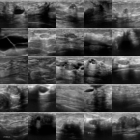

In [9]:
# montage

train_dataset.montage(length=5)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [9]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [10]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 37/37 [00:02<00:00, 13.88it/s]


In [11]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.985  acc:0.945
test  auc: 0.947  acc:0.853


# We then check a 2D dataset with size 224x224

In [21]:
data_flag = 'breastmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=28, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = DataClass(split='test', transform=data_transform, download=download, size=28, mmap_mode='r')
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [11]:
x_single, y_single = train_dataset[0]

print(x_single.shape, y_single.shape)

torch.Size([1, 28, 28]) (1,)


## Then we train and evaluate on this 224x224 dataset

In [30]:
from torchvision.models import resnet18

model = resnet18(num_classes=n_classes)
# Modify the first convolutional layer to accept 1-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=3, bias=False)

criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [31]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()


100%|██████████| 9/9 [00:02<00:00,  3.00it/s]


In [32]:
split = 'train'

model.eval()
y_true = torch.tensor([])
y_pred = torch.tensor([])

data_loader = train_loader_at_eval if split == 'train' else test_loader

with torch.no_grad():
    for inputs, targets in data_loader:
        outputs = model(inputs)
        outputs = outputs.softmax(dim=-1)
        predictions = torch.argmax(outputs, dim=-1)
        y_pred = torch.cat((y_pred, predictions), 0)
        y_true = torch.cat((y_true, targets.squeeze()), 0)

    y_pred = y_pred.detach().numpy()
    y_true = y_true.detach().numpy()
    
    evaluator = Evaluator(data_flag, split, size=28)
    metrics = evaluator.evaluate(y_pred)

    print('%s  auc: %.3f  acc: %.3f' % (split, *metrics))

train  auc: 0.500  acc: 0.731


In [33]:
print(y_pred.shape)
print(y_true.shape)

(546,)
(546,)


In [34]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

546
156


In [35]:
for inputs, targets in test_loader:
    print(inputs.shape, targets.shape)
    break  # Access only the first batch
# print(inputs[0])

torch.Size([128, 1, 28, 28]) torch.Size([128, 1])


## Start FACELIFT

In [36]:
train_imgs = []

for inputs, targets in train_loader:
    # Reshape each image from (28, 28) to (784,)
    reshaped_inputs = inputs.view(inputs.size(0), -1)  # Reshaping to (batch_size, 784)
    train_imgs.append(reshaped_inputs.numpy())

train_imgs = np.concatenate(train_imgs, axis=0)
train_imgs = train_imgs.astype("float32")

print(train_imgs.shape)  

(546, 784)


In [37]:
@jit(nopython=True)
def calculate_weighted_distance(v0, v1, penalty_term = 2):
    diff = np.subtract(v0, v1)
    reweight_vector = np.where(diff>=0, 1, -penalty_term)
    weighted_diff = np.linalg.norm(diff*reweight_vector)
    return weighted_diff

def get_weights_kNN(
    X, 
    n_neighbours = 20,
    penalty_term = 2,
    weight_func = None 
    ):
    n_samples, n_ftrs = X.shape
    
    k = np.zeros((n_samples, n_samples))
    W = k.copy()
    # X = X.to_numpy()

    for i in tqdm(range(n_samples)):
        v0 = X[i]
        for j in range(n_samples):
            v1 = X[j]
            # modify the distance function so that removing pixels incurring larger cost.
            # dist = calculate_weighted_distance(v1, v0, penalty_term=penalty_term)
            dist = np.linalg.norm(v0 - v1)      # unweighted distance
            k[i, j] = dist
            if dist != 0:
                W[i,j] = weight_func(dist)
        
        t = np.argsort(k[i, :])[(n_neighbours+1):]
        mask = np.ix_(t)
        # k[i, mask] = 0
        W[i, mask] = 0
        
    return W

In [38]:
def construct_graph(weight_matrix):
    graph = csr_matrix(weight_matrix)
    return graph

def find_shortest_path(graph, start_point_idx):
    dist_matrix, predecessors = csgraph.dijkstra(
        csgraph=graph, directed=True, indices=start_point_idx, return_predecessors=True
    )
    return dist_matrix, predecessors

def reconstruct_shortest_path(predecessors, start_point_idx, end_point_idx):
    """Get all the nodes along the path between the start point and the end point. 

    Args:
        predecessors (matrix of shape (1, n_nodes)): contain the previous node in the path.
        start_point_idx (int): the index of the start data point
        end_point_idx (int): the index of the end data point

    Returns:
        node_path (list): [start_point_idx, intermedium points index, end_point_idx]
    """
    if predecessors[end_point_idx] == start_point_idx:
        node_path = [end_point_idx]
    else:
        node_path = []
    intermedium_idx = end_point_idx
    while (predecessors[intermedium_idx] != start_point_idx):
        node_path.append(intermedium_idx)
        intermedium_idx = predecessors[intermedium_idx]
    if intermedium_idx != node_path[-1]:
        node_path.append(intermedium_idx)
    node_path.append(start_point_idx)
    
    return node_path[::-1]
 
def build_symmetric_matrix(kernel):
     # Keep all non-zero entries and make the matrix symmetric
    return np.maximum(kernel, kernel.T)

def build_asymmetric_matrix(kernel, X, weight_func, penalty_term):
    n_samples = kernel.shape[0]
    X = X.to_numpy()
    for i in tqdm(range(n_samples)):
        for j in range(n_samples):
            if kernel[i,j] != 0:
                v0 = X[i]
                v1 = X[j]
                dist = calculate_weighted_distance(v0, v1, penalty_term=penalty_term)
                kernel[j, i] = weight_func(dist)
    return kernel

In [39]:
# get the prediction results for all train data
predictions = y_pred
X = train_imgs
print(predictions.shape)

(546,)


In [64]:
n_neighbours = 10
penalty_term = 1
n_samples, n_features = X.shape

def get_volume_of_sphere(d):
    return math.pi**(d/2)/math.gamma(d/2 + 1)

volume_sphere = get_volume_of_sphere(1)
r = (n_neighbours / (n_samples * volume_sphere))

print(n_samples, n_features, r)

# Construct the global weighted graph.
# Kernel is asymmetric if using KNN to get weight, and OG only keeps the bottom left half of the matrix
weight_func=lambda x: -x*np.log(r/x)  # x**alpha
kernel = get_weights_kNN(
            X,
            penalty_term=penalty_term,
            n_neighbours=int(n_neighbours),
            weight_func=weight_func
        )

sym_kernel = build_symmetric_matrix(kernel)


546 784 0.009157509157509156


100%|██████████| 546/546 [00:00<00:00, 616.54it/s]


In [41]:
print(np.sum(sym_kernel != 0, axis=1))  # Number of non-zero entries for each point

[15 12 18 24 13 15 11 15 12 13 10 23 34 25 13 10 12 11 12 15 15 11 11 11
 15 55 13 19 14 14 10 10 10 11 41 15 11 10 19 23 13 12 11 11 12 10 41 12
 28 14 21 13 20 11 11 11 10 17 23 12 17 11 27 30 11 11 13 16 46 10 10 10
 12 18 11 21 19 13 48 11 12 29 15 22 10 10 12 12 10 19 10 15 11 18 10 18
 10 11 24 16 10 10 16 10 19 28 18 12 21 14 13 17 18 20 13 28 12 12 15 24
 14 11 18 10 24 28 22 14 13 22 11 10 11 13 17 11 20 13 11 11 11 13 10 16
 13 18 15 16 10 17 10 25 11 18 15 47 11 28 22 42 14 44 10 10 10 12 12 11
 13 21 12 13 10 25 24 18 13 14 28 11 11 12 15 11 10 15 30 13 10 10 10 15
 11 11 10 10 14 12 10 12 10 14 15 12 29 15 62 10 10 29 12 12 10 10 22 10
 15 17 29 11 13 16 12 21 13 17 14 21 13 10 22 11 45 16 15 15 12 37 21 10
 14 10 10 10 12 23 12 11 10 10 12 11 10 13 11 11 13 27 10 12 23 30 14 11
 16 10 11 16 80 12 19 14 30 10 12 17 24 15 10 10 12 39 10 11 10 10 27 41
 59 10 30 17 10 12 13 18 11 12 13 12 10 19 12 10 10 10 16 17 13 25 11 13
 15 12 12 12 13 14 12 14 10 24 14 10 15 12 11 11 10

In [49]:
def get_minimum_dist(dist_matrix):
    """get the shortest distance and its data index
    Args:
        dist_matrix (array): shape: 1 x n_nodes

    Returns:
        min_dist: minimum distance in the distance matrix
        min_dist_idx: index of the data point with the shortest dist
    """
    min_dist = np.min(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False)) 
    min_dist_idx = np.argmin(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False))
    return min_dist, min_dist_idx

def get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths = 1, pred_threshold=0.55):
    assert num_paths > 0 and isinstance(num_paths, int), "only positive integers"
    end_point_idx = []
    path_count = 0
    for idx in np.argsort(np.ma.masked_where(dist_matrix==0, dist_matrix))[10:]:
        if (y[idx] == target_class): # and
        # predictions[idx, class_labels.index(target_class)] >= pred_threshold): 
            end_point_idx.append(idx)
            if path_count >= num_paths-1:
                break
            else:
                path_count += 1
    return end_point_idx

def get_user_agency(sp_graph, start_point_idx, alternative_classes, predictions, y, class_labels, pred_threshold=0.55):
    dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx)
    alt_class_dict = {}
    alt_path_dict = {}
    for alt_class in alternative_classes:
        alt_end_idx = get_closest_cf_point(dist_matrix, predictions, y, alt_class, class_labels, pred_threshold = pred_threshold)
        alt_end_dist = dist_matrix[alt_end_idx[0]]
        alt_class_dict[alt_class] = {alt_end_idx[0]: alt_end_dist}
        
        alt_end_path = reconstruct_shortest_path(predecessors, start_point_idx, alt_end_idx[0])
        alt_path_dict[alt_class] = {alt_end_idx[0]: alt_end_path}
    
    return alt_class_dict, alt_path_dict

In [43]:
def calculate_dist_alter_cf(sp_graph, predictions, y, class_labels, inter_point_idx, target_class, count):
    dist_matrix_alter, predecessors_alter = find_shortest_path(sp_graph, start_point_idx=inter_point_idx)
    end_point_idx_alter = get_closest_cf_point(dist_matrix_alter, predictions, y, target_class, class_labels, num_paths=10)
    shortest_path_alter = reconstruct_shortest_path(predecessors_alter, start_point_idx=inter_point_idx, end_point_idx=end_point_idx_alter[count])
    # plot_digits(shortest_path_alter)
    dist = dist_matrix_alter[end_point_idx_alter[count]]
    return dist

# single class
def calculate_shared_perc(dist_matrix, path_idx, params, alter_class, count):
    point_count = len(path_idx)
    if point_count == 2:    # no intermediate points
        final_point_dist = calculate_dist_alter_cf(params["sp_graph"], params["predictions"], params["y"], params["class_labels"], path_idx[1], target_class=alter_class, count=count)
        start_point_dist = calculate_dist_alter_cf(params["sp_graph"], params["predictions"], params["y"], params["class_labels"], path_idx[0], target_class=alter_class, count=count)
        # print(start_point_dist, final_point_dist)
        if final_point_dist > start_point_dist:
            shared_perc = 0
        else:
            shared_perc = 1
    else:
        for i in range(point_count-2):
            current_point_dist = calculate_dist_alter_cf(params["sp_graph"], params["predictions"], params["y"], params["class_labels"], path_idx[i], target_class=alter_class, count=count)
            next_point_dist = calculate_dist_alter_cf(params["sp_graph"], params["predictions"], params["y"], params["class_labels"], path_idx[i+1], target_class=alter_class, count=count)
            # print(current_point_dist, next_point_dist)
            if next_point_dist > current_point_dist:
                termination_point = path_idx[i]
                break
            else:
                termination_point = path_idx[i+1]
        shared_perc = dist_matrix[termination_point]/dist_matrix[path_idx[-1]]
    return shared_perc

def calculate_avg_shared_perc(dist_matrix, path_idx, params, alter_classes):
    avg_shared_perc_list = []
    for count, y_prime in enumerate(alter_classes):
        shared_perc = calculate_shared_perc(dist_matrix, path_idx, params, y_prime, count)
        avg_shared_perc_list.append(shared_perc)
        # print(shared_perc)
    avg_shared_perc = np.mean(avg_shared_perc_list)
    # std_shared_perc = np.std(avg_shared_perc_list)
    return avg_shared_perc


def find_highest_shared_perc(dist_matrix, params, alter_classes, all_paths, top_num=5):
    all_paths_dict = list(all_paths.values())[0]
    highest_shared_perc = 0
    highest_path_id = None
    shortest_path_info = {
        "dist": dist_matrix[all_paths_dict[0][-1]],
        "path_rank": 0,
        "path_shared_perc": calculate_avg_shared_perc(dist_matrix, all_paths_dict[0], params, alter_classes)
    }
    for count, path_idx in all_paths_dict.items():
        if count >= top_num:
            break
        avg_shared_perc = calculate_avg_shared_perc(dist_matrix, path_idx, params, alter_classes)
        # print(avg_shared_perc)
        if avg_shared_perc >= highest_shared_perc:
            highest_shared_perc = avg_shared_perc
            highest_path_id = count

    highest_shared_path_info = {
        "dist": dist_matrix[all_paths_dict[highest_path_id][-1]],
        "path_rank": highest_path_id,
        "path_shared_perc": highest_shared_perc
    }
    return shortest_path_info, highest_shared_path_info

In [44]:
np.where(predictions==1)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [ ]:
def find_paths_for_one(sp_graph, start_point_idx, target_class, params, num_paths):
    res = {}
    res[start_point_idx] = {}
    dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx=start_point_idx)

    end_point_indices = get_closest_cf_point(dist_matrix, params["predictions"], params["y"], target_class, params["class_labels"], num_paths=num_paths)
    # print(end_point_indices)

    for order, end_point_idx in enumerate(end_point_indices):
        shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=end_point_idx)
        # flag = 0
        for node_idx in shortest_path[:-1]:
            # print(np.argmax(predictions[node_idx]))
            if np.argmax(predictions[node_idx]) not in [1, target_class]:
                flag = 1
            res[start_point_idx][order] = shortest_path
    # print(res)
    return res, dist_matrix

sp_graph = construct_graph(sym_kernel)
start_point_idx = 1    
target_class = 0
params = {
    "sp_graph": sp_graph,
    "predictions": predictions,
    "y": y_true,
    "class_labels": list(map(int, np.array(["0","1"]))),
}
alter_classes = [0]
# alternative_classes = list(set(class_labels) - set([target_class, y[start_point_idx]]))
all_paths, dist_matrix = find_paths_for_one(sp_graph, start_point_idx, target_class, params, num_paths=20)
shortest_path_info, highest_shared_path_info = find_highest_shared_perc(dist_matrix, params, alter_classes, all_paths, top_num=20)
print(all_paths)
print(shortest_path_info)
print(highest_shared_path_info)

{1: {0: [1, 310], 1: [1, 220, 340], 2: [1, 220, 312], 3: [1, 384, 122], 4: [1, 268, 316], 5: [1, 268, 261], 6: [1, 268, 287], 7: [1, 225, 403], 8: [1, 46, 377], 9: [1, 268, 314], 10: [1, 157, 534], 11: [1, 268, 475], 12: [1, 157, 378], 13: [1, 157, 345], 14: [1, 268, 357], 15: [1, 268, 333], 16: [1, 376, 230], 17: [1, 46, 118], 18: [1, 376, 417], 19: [1, 384, 183]}}
{'dist': 22.91737382405612, 'path_rank': 0, 'path_shared_perc': 0.0}
{'dist': 37.34280867568841, 'path_rank': 8, 'path_shared_perc': 0.5570328068760292}


In [72]:
all_one_indices = list(np.where(predictions==1)[0])[:100]

face_shared_perc_list = []
face_dist_list = []
facelift_shared_perc_list = []
facelift_dist_list = []
step_count = []

for factual_point_idx in all_one_indices:
    all_paths, dist_matrix = find_paths_for_one(sp_graph, factual_point_idx, target_class, params, num_paths=20)
    shortest_path_info, highest_shared_path_info = find_highest_shared_perc(dist_matrix, params, alter_classes, all_paths, top_num=10)

    face_shared_perc_list.append(shortest_path_info["path_shared_perc"])
    face_dist_list.append(shortest_path_info["dist"])
    facelift_shared_perc_list.append(highest_shared_path_info["path_shared_perc"])
    facelift_dist_list.append(highest_shared_path_info["dist"])
    step_count.append(len(all_paths[factual_point_idx][0]))
print("shared percentage of paths from face: {}, std: {}".format(round(np.mean(face_shared_perc_list), 2), round(np.std(face_shared_perc_list), 2)))
print("average distance of shortest path: {}, std: {} ".format(round(np.mean(face_dist_list), 2), round(np.std(face_dist_list), 2)))
print("shared percentage of paths from facelift: {}, std: {}".format(round(np.mean(facelift_shared_perc_list), 2), round(np.std(facelift_shared_perc_list), 2)))
print("average distance of path with maximised shared percentage: {}, std: {}".format(round(np.mean(facelift_dist_list), 2), round(np.std(facelift_dist_list), 2)))
print("common count: ", (round(np.mean(step_count), 2)), (round(np.std(step_count), 2)))


shared percentage of paths from face: 0.31, std: 0.37
average distance of shortest path: 28.58, std: 9.41 
shared percentage of paths from facelift: 0.64, std: 0.19
average distance of path with maximised shared percentage: 35.03, std: 8.08
common count:  2.47 0.5


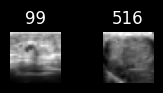

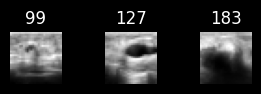

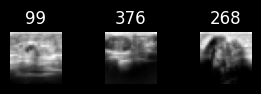

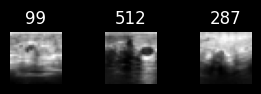

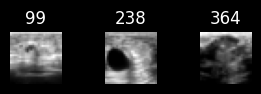

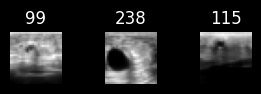

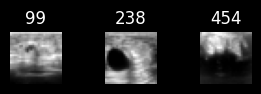

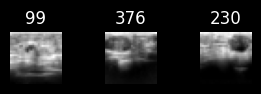

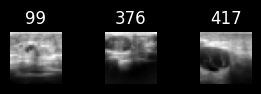

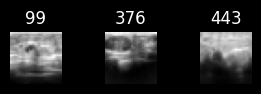

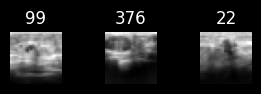

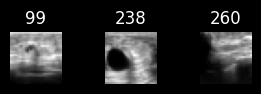

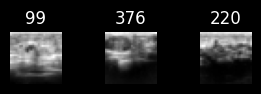

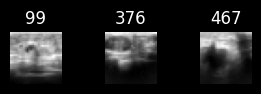

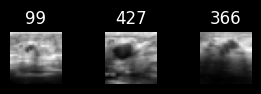

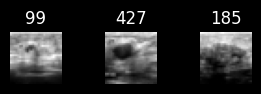

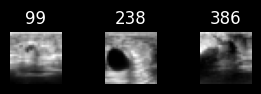

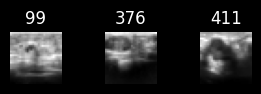

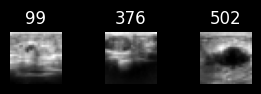

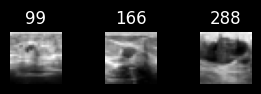

In [70]:
for point_idx, paths in all_paths.items():
    for paths_key, path_idx_list in paths.items():
        # Create a subplot for each path (one row, multiple columns)
        fig, axes = plt.subplots(1, len(path_idx_list), figsize=(len(path_idx_list), 1))

        for ax, path_idx in zip(axes, path_idx_list):
            ax.imshow(train_dataset.imgs[path_idx], cmap='gray')
            ax.set_title(path_idx)
            ax.axis("off")  
        
        plt.tight_layout() 
        plt.show()